# Algorithmic Feedback Synthesis for Robust Strong Invariance of Continous Control Systems

In [ ]:
looks_cool = {1:1, 2:2, 3:3}
print(looks_cool.__class__)
print(looks_cool[2])

<class 'dict'>
2


In [ ]:
#@title Install Required Libraries
%%capture
!pip install pygad
!pip install gradient_free_optimizers
!pip install line_profiler
%load_ext line_profiler

# The link below can be referred for more information about profiling the code line by line
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=lRMD7pePczP1
# https://stackoverflow.com/questions/70303330/how-can-i-do-lprun-work-on-nested-function-in-python

In [ ]:
#@title Parameters
import numpy as np

check_list = ["Warnings", "1.Check Gradient Initial Guess Function for more complicated situations"]
# Problem Parameters
problem_dict = {1: "Moore Greitzer",\
                2: "Rigid Body Motion"}
problem = problem_dict[2]
if problem == problem_dict[1]:
        ellipsoid_constants = np.array([0.2, 0.15])
        ellipsoid_centre = np.array([0.05, -0.06])
        max_noise = 0
        dim_v = 2
        dim_m = 1
        max_degree = 1
        len_dict = dim_m*(max_degree + 1)**dim_v
        eta_bound = 100
        u_max_norm = 5
        print_point = 1
        EPSILON_HAMILTONIAN = 1E-2
        MAX_VAL = 10e8
        mv_indices = {1:2}
elif problem == problem_dict[2]:
        ellipsoid_constants = np.array([0.3, 0.2, 0.3])
        ellipsoid_centre = np.array([0.1, 0, 0.1])
        max_noise = 0
        dim_v = 3
        dim_m = 2
        max_degree = 1
        len_dict = dim_m*(max_degree + 1)**dim_v
        eta_bound = 100
        u_max_norm = 5
        print_point = 1
        EPSILON_HAMILTONIAN = 1E-2
        MAX_VAL = 10e8
        mv_indices = {1:1, 2:2}
#Derived parameters
dim_theta = len_dict*(dim_v - 1)
max_bound_array = 2* np.pi*np.ones(dim_theta)
min_bound_array = np.zeros(dim_theta)
bounds_array = (min_bound_array, max_bound_array)

number_of_mesh_points = 10

#Inner Minimization Parameters
method_innermin = 'SLSQP'
minimization_tol = 1e-2
inner_min_exponent = 2
#PSO Parameters
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
n_particles = 5
PSO_iters = 10
utol = 'ftol' if method_innermin == 'SLSQP' else 'tol'

#GA Parameters
num_genes = dim_theta
num_generations = 10
sol_per_pop = 10
num_parents_mating = sol_per_pop
GA_low_bound = 0
GA_high_bound = 2*np.pi
parent_selection_type = 'rws'

#Plotting Parameters
discretization = {1:100, 2:50, 3:10}
k_discrete = discretization[dim_v]

#Define kwargs
kwargs={"ellipsoid_constants" : ellipsoid_constants,\
        "ellipsoid_centre": ellipsoid_centre, \
        "max_noise": max_noise,\
        "len_dict": len_dict,\
        "dim_v" : dim_v,\
        "dim_m": dim_m, \
        "max_degree": max_degree,\
        "u_max_norm": u_max_norm,\
        "eta_bound" : eta_bound,\
        "print_point" : print_point}


In [ ]:
#@title Dictionary Creation

from sympy import symbols, lambdify, Array, MutableDenseNDimArray
import numpy as np
from itertools import product
import re
import numpy as np

def evaluate_polynomials(degree, values, m):
    # Create symbolic variables x1, x2, ..., xv
    variables = symbols('x:{}'.format(len(values)))

    # Generate all combinations of exponents up to the given degree
    exponents = product(range(degree + 1), repeat=len(values))

    # Create and evaluate polynomials
    evaluated_polynomials = {}
    for exp in exponents:
        for i in range(1, m + 1):
            vector_name = f'Vector {exp + (i,)}'  # Include i in the vector name
            # Create the polynomial expression
            polynomial_expr = 1  # Initialize with 1 for multiplication
            for var, e in zip(variables, exp):
                polynomial_expr *= var**e

            # Evaluate the polynomial for the given values
            numerical_value = lambdify(variables, polynomial_expr, 'numpy')(*values)

            # Store the result in the dictionary
            evaluated_polynomials[vector_name] = numerical_value

    return evaluated_polynomials

def extract_inside_parentheses(input_string):
    # Define a regular expression pattern to match content inside parentheses
    pattern = r'\((.*?)\)'

    # Use re.findall to find all matches
    matches = re.findall(pattern, input_string)

    # Return the matches (content inside parentheses)
    return matches

def create_vector_dict(evaluated_polynomials, m):
    vector_dict = {}
    for key, value in evaluated_polynomials.items():
        # Extract exponents from the key
        location = int(extract_inside_parentheses(key)[0].split(',')[-1]) - 1
        #vector = np.zeros(m).
        #Commented, to be changed.
        vector_mutable = MutableDenseNDimArray(np.zeros((m), dtype=float))
        vector = np.array(vector_mutable).astype(np.float64)
        vector[location] = value  # Set the i-th element of the vector
        vector_dict[key] = vector

    return vector_dict

def create_symbolic_dict(evaluated_polynomials, m):
    vector_dict = {}
    for key, value in evaluated_polynomials.items():
        # Extract exponents from the key
        location = int(extract_inside_parentheses(key)[0].split(',')[-1]) - 1
        #vector = np.zeros(m).
        #Commented, to be changed.
        vector_mutable = MutableDenseNDimArray(np.zeros((m), dtype=float))
        vector_mutable[location] = value  # Set the i-th element of the vector
        vector_dict[key] = vector_mutable
    return vector_dict

def generate_scalars(input_dict, eta_array):
    result_dict = {}
    d = len(eta_array)
    i = 0
    for key, value in input_dict.items():
        result_dict[key] = eta_array[i]
        i += 1
    return result_dict

def compute_feedback(vector_dict, coeff_dict):
    """
    Compute the sum of matrix-vector products across keys in two dictionaries.

    Parameters:
    - dict1: Dictionary with keys and numpy arrays (vectors) as values.
    - dict2: Dictionary with keys and numpy arrays (matrices) as values.

    Returns:
    - The sum of matrix-vector products.
    """
    result = sum(coeff_dict[key]*vector_dict[key] for key in vector_dict)
    return result

def generate_initial_gradiental_guess(ellipsoid_constants, ellipsoid_centre, len_dict, dim_v, \
                                            dim_m, max_degree, indices = {1:1}):
  #The number of indices in "indices" should be equal to dim_m. the "indices" dictionary is a mapping from j --> i
  #i is the dimension \in {1,2,...,dim_v} while j is the component \in {1, 2, ..., dim_m}
  #then we have t(v,k,m,i,j) = m*(1 + k)**(v - i) + j - 1 (using zero indexing)
  #for the onehot vectors: t(i,j,m) = j - 1 (using zero indexing)
  blank_array = np.zeros(len_dict)
  #Setting the constant terms first
  for j in indices.keys():
    i = indices[j]
    blank_array[j - 1] = ellipsoid_centre[i - 1]/(ellipsoid_constants[i - 1]**2)
  #Now setting the linear terms
  for j in indices.keys():
    i = indices[j]
    t_ij = dim_m*(1 + max_degree)**(dim_v - i) + j - 1
    blank_array[t_ij] = -1/(ellipsoid_constants[i - 1]**2)
  norm_array = blank_array/np.linalg.norm(blank_array) if np.linalg.norm(blank_array) > 0 else blank_array
  return norm_array


gradient_guess = generate_initial_gradiental_guess(ellipsoid_constants, ellipsoid_centre, len_dict, dim_v, \
                                            dim_m, max_degree, mv_indices)

In [ ]:
%%time
the_degree = 3
the_v = 3
values = [symbols(f'x{i}') for i in range(1, the_v + 1)]  # 3-dimensional
the_m = 3
result_inter = evaluate_polynomials(the_degree, values, the_m)
result = create_symbolic_dict(result_inter, the_m)
# Print the results
for vector_name, numerical_value in result.items():
    print(f'{vector_name}: {numerical_value}')

print(result["Vector (0, 2, 3, 3)"])

Vector (0, 0, 0, 1): [1, 0.0, 0.0]
Vector (0, 0, 0, 2): [0.0, 1, 0.0]
Vector (0, 0, 0, 3): [0.0, 0.0, 1]
Vector (0, 0, 1, 1): [x3, 0.0, 0.0]
Vector (0, 0, 1, 2): [0.0, x3, 0.0]
Vector (0, 0, 1, 3): [0.0, 0.0, x3]
Vector (0, 0, 2, 1): [x3**2, 0.0, 0.0]
Vector (0, 0, 2, 2): [0.0, x3**2, 0.0]
Vector (0, 0, 2, 3): [0.0, 0.0, x3**2]
Vector (0, 0, 3, 1): [x3**3, 0.0, 0.0]
Vector (0, 0, 3, 2): [0.0, x3**3, 0.0]
Vector (0, 0, 3, 3): [0.0, 0.0, x3**3]
Vector (0, 1, 0, 1): [x2, 0.0, 0.0]
Vector (0, 1, 0, 2): [0.0, x2, 0.0]
Vector (0, 1, 0, 3): [0.0, 0.0, x2]
Vector (0, 1, 1, 1): [x2*x3, 0.0, 0.0]
Vector (0, 1, 1, 2): [0.0, x2*x3, 0.0]
Vector (0, 1, 1, 3): [0.0, 0.0, x2*x3]
Vector (0, 1, 2, 1): [x2*x3**2, 0.0, 0.0]
Vector (0, 1, 2, 2): [0.0, x2*x3**2, 0.0]
Vector (0, 1, 2, 3): [0.0, 0.0, x2*x3**2]
Vector (0, 1, 3, 1): [x2*x3**3, 0.0, 0.0]
Vector (0, 1, 3, 2): [0.0, x2*x3**3, 0.0]
Vector (0, 1, 3, 3): [0.0, 0.0, x2*x3**3]
Vector (0, 2, 0, 1): [x2**2, 0.0, 0.0]
Vector (0, 2, 0, 2): [0.0, x2**2, 0.0

In [ ]:
#@title Genetic Algorithm Functions
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
import pygad
import time

def fitness_func(ga_instance, solution, solution_idx):
    """Higher-level method to compute the fitness value of the chromosome
    Inputs
    ------
    The instance of the GA, the solution that is passed, the index of the solution
    Returns
    -------
    A scalar which is the fitness of the chromosome
    """
    t1 = time.time()
    fitness_value, _ = optimize_program_when_x_is_ellipsoid(solution, **kwargs)
    t2 = time.time()
    return fitness_value


fitness_function = fitness_func

def on_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

In [ ]:
#@title Inner Optimization Loop
import numpy as np
from scipy.optimize import minimize
import time
#import gradient_free_optimizers as gradfree

def compute_objective_function_on_mesh(phase = 0):
  if dim_v == 2:
    meshbase = np.linspace(0 + phase, 2*np.pi + phase, number_of_mesh_points)
    mesh = []
    for i in range(0, len(meshbase)):
      mesh.append(np.array([meshbase[i]]))
    evalpoly_list = []
    psidictlist = []
    ylist = []
    ygradlist = []
    for i in range(0, len(mesh)):
      y, y_grad = forward_model_single(mesh[i], dim_v, ellipsoid_constants, ellipsoid_centre)
      ylist.append(y)
      ygradlist.append(y_grad)
      evaluated_polynomials = evaluate_polynomials(max_degree, ylist[i], dim_m)
      evalpoly_list.append(evaluated_polynomials)
      psi_dict = create_vector_dict(evaluated_polynomials, dim_m)
      psidictlist.append(psi_dict)
  print("Returning y, yg, ep, pd")
  return ylist, ygradlist, evalpoly_list, psidictlist



def forward_model_theta_to_y(theta_flat, len_dict, dim_v, ellipsoid_constants, ellipsoid_centre):
  theta_reshape = theta_flat.reshape((len_dict, (dim_v - 1)))
    # Inputs: 1. Theta_flat, a numpy array of length |D|*(v - 1)
    #         2. len_dict = size of the dictionary = |D|
    #         3. dim_v = dimension of the v-space
    #         4. ellipsoid_constants, an  array of length v, which defines the ellipsoid's axis constants
    #         5. ellipsoid_centre, an array of length v, which defines the ellipse's center
    # Hidden: Theta_reshape, obtained by reshaping theta_flat to (|D|, v - 1)
    # Output: y, an array of size (|D|, v), obtained by using the forward model to switch from polar to Cartesian coordinates
  #Computing y
  y = np.ones((len_dict, dim_v))
  for d in range(0, len_dict):
    y[d] *= ellipsoid_constants
    for i in range(0, dim_v):
      if i < (dim_v - 1):
        for j in range(0, i):
          y[d][i] *= np.sin(theta_reshape[d][j])
        y[d][i] *= np.cos(theta_reshape[d][i])
      if i == (dim_v - 1):
        for j in range(0, i):
          y[d][i] *= np.sin(theta_reshape[d][j])
    y[d] += ellipsoid_centre
  #Computing grad_y
  grad_y = np.ones((len_dict, dim_v))
  for d in range(0, len_dict):
    grad_y[d] *= 2*(y[d] - ellipsoid_centre)/(ellipsoid_constants**2)
    norm_grad = np.linalg.norm(grad_y[d])
    grad_y[d] = grad_y[d]/norm_grad
  return y, grad_y


def compute_x_dot_noisy(y_array, y_norm_grad, feedback, dim_v, dim_m, max_noise, k):
  #Problem dependent part

  if problem == 'Moore Greitzer':
    f_array = np.zeros(dim_v)
    f_array[0] = -y_array[k][1] - 1.5*y_array[k][0]**2 -0.5*y_array[k][0]**3
    f_array[1] = 0
    g_matrix = np.array([[0], [1]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad[k]
    h_array = np.array([[0, 1], [0, 0]])
    w_array = np.dot(h_array, w)

  elif problem == 'Rigid Body Motion':
    f_array = np.zeros(dim_v)
    f_array[0] = 0
    f_array[1] = 0
    f_array[2] = y_array[k][0]*y_array[k][1]
    g_matrix = np.array([[1, 0], [0, 1], [0, 0]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad[k]
    h_array = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    w_array = np.dot(h_array, w)

  return f_array + g_array + w_array

def is_u_admissible(feedback, max_norm):
  phi = -1
  return phi

#@title Inner Minimization Assuming Ellipsoidal $\mathbb{X}$

def optimize_program_when_x_is_ellipsoid(theta_array,  \
                                         ellipsoid_constants, ellipsoid_centre,\
                                          max_noise, len_dict, dim_v, \
                                            dim_m, max_degree, u_max_norm, \
                                              eta_bound, print_point = 0):
    start_time_in = time.time()
    y, y_norm_grad = forward_model_theta_to_y(theta_array, len_dict, dim_v, ellipsoid_constants, ellipsoid_centre)
    dimension_d = len_dict
    num_obj_computations = 0
    num_const1_comp = 0
    num_const2_comp = 0
    t_const1 = 0
    t_const2 = 0

    def objective_function(x):
      global num_obj_computations
      sum = 0
      for i in range(0, len(x)):
        sum += np.abs(x[i]**inner_min_exponent)
      # sum = 0
      # for k in range(len_dict):
      #   evaluated_polynomials = evaluate_polynomials(max_degree, y[k], dim_m)
      #   psi_dict = create_vector_dict(evaluated_polynomials, dim_m)
      #   eta_psi  = generate_scalars(psi_dict, x)
      #   feedback = compute_feedback(eta_psi, psi_dict)
      #   #Problem Dependent
      #   x_dot_noisy = compute_x_dot_noisy(y, y_norm_grad, feedback, dim_v, dim_m, max_noise, k)
      #   sum += -np.dot(y_norm_grad[k], x_dot_noisy)/np.linalg.norm(x_dot_noisy)
      # num_obj_computations += 1
      return sum

    def bounds_function(i):
        return (None, None)  # x[i] >= 0, where None means no upper bound

    # Create a list of bounds using the dynamically created functions
    bounds = [bounds_function(i) for i in range(0, len_dict)]

    # Define the constraint function based on the provided expression
    def constraint_function1(x, k):
      global t_const1
      t1 = time.time()
      evaluated_polynomials = evaluate_polynomials(max_degree, y[k], dim_m)
      psi_dict = create_vector_dict(evaluated_polynomials, dim_m)
      eta_psi  = generate_scalars(psi_dict, x)
      feedback = compute_feedback(eta_psi, psi_dict)
      #Problem Dependent
      x_dot_noisy = compute_x_dot_noisy(y, y_norm_grad, feedback, dim_v, dim_m, max_noise, k)
      t2 = time.time()
      #num_const1_comp += 1
      # t_const1 += t2 - t1
      return np.dot(y_norm_grad[k], x_dot_noisy) + EPSILON_HAMILTONIAN

    def constraint_function2(x, k):
      global num_const2_comp, t_const2
      t1 = time.time()
      evaluated_polynomials = evaluate_polynomials(max_degree, y[k], dim_m)
      psi_dict = create_vector_dict(evaluated_polynomials, dim_m)
      eta_psi  = generate_scalars(psi_dict, x)
      feedback = compute_feedback(eta_psi, psi_dict)
      t2 = time.time()
      # num_const2_comp += 1
      # t_const2 += t2 - t1
      return is_u_admissible(feedback, u_max_norm)

    # Define a list to store the constraint functions
    constraint_functions1 = [lambda x, k=k: -constraint_function1(x, k) for k in range(dimension_d)]
    constraint_functions2 = [lambda x, k=k: -constraint_function2(x, k) for k in range(dimension_d)]
    merged_constraint_functions = constraint_functions1 + constraint_functions2

    # Create a list of constraints using the dynamically created functions
    constraints = [{'type': 'ineq', 'fun': func} for func in merged_constraint_functions]
    # Initial guess
    initial_guess = gradient_guess

    # Minimization using scipy.optimize
    result = minimize(objective_function, initial_guess, method=method_innermin, bounds=bounds, constraints=constraints, \
                      options={'disp': False,  utol: minimization_tol})

    # Return the optimal solution and objective function value
    evaluated_polynomials = evaluate_polynomials(max_degree, y[0], dim_m)
    psi_dict_optimal = create_vector_dict(evaluated_polynomials, dim_m)
    eta_psi_optimal  = generate_scalars(psi_dict_optimal, result.x)
    feedback_optimal = compute_feedback(psi_dict_optimal, eta_psi_optimal)

    if result.success == True:
      if print_point == 0:
        return result.fun
      elif print_point == 1:
        return result.fun, result.x
    elif result.success == False:
      if print_point == 0:
        return MAX_VAL
      elif print_point == 1:
        return MAX_VAL, result.x


def forward_model_single(theta, dim_v, ellipsoid_constants, ellipsoid_centre):
    # Inputs: 1. Theta_flat, a numpy array of length |D|*(v - 1)
    #         2. len_dict = size of the dictionary = |D|
    #         3. dim_v = dimension of the v-space
    #         4. ellipsoid_constants, an  array of length v, which defines the ellipsoid's axis constants
    #         5. ellipsoid_centre, an array of length v, which defines the ellipse's center
    # Hidden: Theta_reshape, obtained by reshaping theta_flat to (|D|, v - 1)
    # Output: y, an array of size (|D|, v), obtained by using the forward model to switch from polar to Cartesian coordinates
  #Computing y
  y = np.ones(dim_v)
  y *= ellipsoid_constants
  for i in range(0, dim_v):
    if i < (dim_v - 1):
      for j in range(0, i):
        y[i] *= np.sin(theta[j])
      y[i] *= np.cos(theta[i])
    if i == (dim_v - 1):
      for j in range(0, i):
        y[i] *= np.sin(theta[j])
  y += ellipsoid_centre
  #Computing grad_y
  grad_y = np.ones(dim_v)
  grad_y *= 2*(y - ellipsoid_centre)/(ellipsoid_constants**2)
  norm_grad = np.linalg.norm(grad_y)
  grad_y = grad_y/norm_grad
  return y, grad_y

def compute_x_dot_noisy_single(y, y_norm_grad, feedback, dim_v, dim_m, max_noise, set_f_0 = False):
  #Problem dependent part

  if problem == 'Moore Greitzer':
    f_array = np.zeros(dim_v)
    f_array[0] = -y[1] - 1.5*y[0]**2 -0.5*y[0]**3
    f_array[1] = 0
    g_matrix = np.array([[0], [1]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad * np.random.rand()
    h_array = np.array([[0, 1], [0, 0]])
    w_array = np.dot(h_array, w)

  elif problem == 'Rigid Body Motion':
    f_array = np.zeros(dim_v)
    f_array[0] = 0
    f_array[1] = 0
    f_array[2] = y[0]*y[1]
    g_matrix = np.array([[1, 0], [0, 1], [0, 0]])
    g_array = np.dot(g_matrix, feedback)
    w  = max_noise * y_norm_grad
    h_array = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    w_array = np.dot(h_array, w)

  if set_f_0 == False:
    return f_array + g_array + w_array
  elif set_f_0 == True:
    return g_array

In [ ]:
print(ellipsoid_constants, ellipsoid_centre, len_dict, dim_v, \
                                            dim_m, max_degree)
print(generate_initial_gradiental_guess(ellipsoid_constants, ellipsoid_centre, len_dict, dim_v, \
                                            dim_m, max_degree, mv_indices))

[0.3 0.2 0.3] [0.1 0.  0.1] 16 3 2 1
[ 0.04058039  0.          0.          0.          0.         -0.91305882
  0.          0.         -0.40580392  0.          0.          0.
  0.          0.          0.          0.        ]


In [ ]:
#@title Verification Loop
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import time

def obtain_optimal_feedback(solution):
    t1 = time.time()
    _, eta_psi_optimal = optimize_program_when_x_is_ellipsoid(solution, **kwargs)
    t2 = time.time()
    print(f"This took {t2 - t1} to complete")
    return eta_psi_optimal

def symbolic_feedback(dim_m, dim_v, max_degree, eta_psi_optimal):
    symbolic_x = [symbols(f'x{i}') for i in range(1, dim_v + 1)]
    basis_pnms = evaluate_polynomials(max_degree, symbolic_x, dim_m)
    basis_vecs_symb =  create_symbolic_dict(basis_pnms, dim_m)
    coefficients = generate_scalars(basis_vecs_symb, eta_psi_optimal)
    optimal_symbolic_feedback = sum(coefficients[key]*basis_vecs_symb[key] for key in coefficients)
    return optimal_symbolic_feedback

def create_hypercube_grid(n, k):
    # Generate a grid for each dimension
    grid = np.linspace(0, 2*np.pi*(1 + 1/k), k, endpoint=False)

    # Create the hypercube grid using meshgrid
    meshgrid_args = [grid] * n
    hypercube_grid = np.meshgrid(*meshgrid_args, indexing='ij')

    # Combine the grid points into a list of n-dimensional points
    points = np.vstack([dimension.flatten() for dimension in hypercube_grid]).T

    return points

def plot_vector_fields(dim_v, ellipsoid_constants, ellipsoid_centre, \
                       k_discrete, eta_psi_optimal):
    thetas = create_hypercube_grid(dim_v - 1, k_discrete)
    theta_list = []
    y_list = []
    f_vecs = []
    g_vecs = []
    f_gu_vecs = []
    dot_products = []
    for i in range(0, thetas.shape[0]):
        y, y_grad = forward_model_single(thetas[i], dim_v, ellipsoid_constants, ellipsoid_centre)
        evaluated_polynomials = evaluate_polynomials(max_degree, y, dim_m)
        psi_dict = create_vector_dict(evaluated_polynomials, dim_m)
        eta_psi  = generate_scalars(psi_dict, eta_psi_optimal)
        feedback = compute_feedback(eta_psi, psi_dict)
        computed_f = compute_x_dot_noisy_single(y, y_grad , np.zeros(dim_m), dim_v, dim_m, max_noise, False)
        computed_g = compute_x_dot_noisy_single(y, y_grad , feedback, dim_v, dim_m, max_noise, True)
        computed_f_gu_w = compute_x_dot_noisy_single(y, y_grad , feedback, dim_v, dim_m, max_noise, False)
        theta_list.append(thetas[i])
        y_list.append(y)
        f_vecs.append(computed_f)
        g_vecs.append(computed_g)
        f_gu_vecs.append(computed_f_gu_w)
        dot_product = np.dot(computed_f_gu_w, y_grad)/(np.linalg.norm(computed_f_gu_w)*np.linalg.norm(y_grad))\
        if (np.linalg.norm(computed_f_gu_w)*np.linalg.norm(y_grad)) > 0 else 0
        dot_products.append(dot_product)
    # Plotting
    if dim_v == 2:
        print("Proceeding to plot in 2 dimensions.")
        x1_values = [point[0] for point in y_list]
        x2_values = [point[1] for point in y_list]
        f1_values = [point[0] for point in f_vecs]
        f2_values = [point[1] for point in f_vecs]
        g1_values = [point[0] for point in g_vecs]
        g2_values = [point[1] for point in g_vecs]
        fg1_values = [point[0] for point in f_gu_vecs]
        fg2_values = [point[1] for point in f_gu_vecs]
        scaling_factor = 2

        fig, axs = plt.subplots(2, 2, figsize=(10, 10))

        axs[0, 0].plot(x1_values, x2_values, color='red')
        axs[0, 0].quiver(x1_values, x2_values, f1_values, f2_values, scale=1/scaling_factor, color='blue')
        axs[0, 0].set_title('Plot 2')

        axs[0, 1].plot(x1_values, x2_values, color='red')
        #axs[0, 1].quiver(x1_values, x2_values, g1_values, g2_values, scale=1/scaling_factor, color='green')
        axs[0, 1].quiver(x1_values, x2_values, fg1_values, fg2_values, scale=1/scaling_factor, color='black')
        axs[0, 1].set_title('Plot 3')

        pcm = axs[1, 0].scatter(x1_values, x2_values, c = np.array(dot_products), cmap = 'turbo')
        plt.colorbar(pcm, ax = axs[1,0])
        # axs[1, 0].quiver(x1_values, x2_values, fg1_values, fg2_values, scale=1/scaling_factor, color='black')
        axs[1, 0].set_title('Plot 4')

        plt.tight_layout()
        axs[1,1].plot(theta_list, dot_products, color='black')
        plt.axhline(0, color='red', linestyle='--', label='y=0')
        axs[1,1].set_title('Plot 5')

        plt.show()
    elif dim_v == 3:
        print("Proceeding to plot in 3 dimensions.")
        x1_values = [point[0] for point in y_list]
        x2_values = [point[1] for point in y_list]
        x3_values = [point[2] for point in y_list]
        f1_values = [point[0] for point in f_vecs]
        f2_values = [point[1] for point in f_vecs]
        f3_values = [point[2] for point in f_vecs]
        g1_values = [point[0] for point in g_vecs]
        g2_values = [point[1] for point in g_vecs]
        g3_values = [point[2] for point in g_vecs]
        fg1_values = [point[0] for point in f_gu_vecs]
        fg2_values = [point[1] for point in f_gu_vecs]
        fg3_values = [point[2] for point in f_gu_vecs]
        ax = plt.figure().add_subplot(projection='3d')
        ax.quiver(x1_values, x2_values, x3_values, \
                  fg1_values, fg2_values, fg3_values, length=0.1, normalize=True)
    return 0

In [ ]:
#@title Main Loop

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
import time
import datetime
# import three_d_naive_plotter

def main_loop():
  print(check_list)
  print("Solving the problem: ", problem)
  print("Length of the dictionary is: ", len_dict)
  print("Dimension of the problem is:", dim_theta)
  print(f"Estimated runtime in minutes is {num_generations*sol_per_pop/2}")
  start_time = time.time()
  #print(compute_objective_function_on_mesh())

  ##GA
  ga_instance = pygad.GA(num_generations=num_generations,
                      num_parents_mating=num_parents_mating,
                      fitness_func=fitness_function,
                      sol_per_pop=sol_per_pop,
                      num_genes=num_genes,
                      parent_selection_type=parent_selection_type,
                      init_range_low=GA_low_bound,
                      init_range_high=GA_high_bound,
                      gene_space=None,
                      save_solutions=True,
                      mutation_type="random",
                      mutation_probability=0.1,
                      on_generation=on_gen,
                      suppress_warnings=True)

  ga_instance.run()
  ga_instance.plot_fitness()
  ga_instance.plot_genes()
  ga_instance.plot_new_solution_rate()

  solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)
  eta_psi_solution = obtain_optimal_feedback(solution)
  optimal_symbolic_feedback = symbolic_feedback(dim_m, dim_v, max_degree, eta_psi_solution)
  print(f"Parameters of the best solution : {solution}")
  print(f"Fitness value of the best solution = {solution_fitness}")
  print(f"The optimal feedback obtained is = {optimal_symbolic_feedback}")
  end_time = time.time()
  runtime_total = end_time - start_time
  runtime_per_loop = runtime_total/num_generations
  runtime_per_organism = runtime_per_loop/sol_per_pop
  print(f"Runtime Statistics. \n Total = {runtime_total}. \n \
        Per Generation = {runtime_per_loop}. \n \
        Per Organism = {runtime_per_organism}")

['Warnings', '1.Check Gradient Initial Guess Function for more complicated situations']
Solving the problem:  Rigid Body Motion
Length of the dictionary is:  16
Dimension of the problem is: 32
Estimated runtime in minutes is 50.0
Generation :  1
Fitness of the best solution : 0.0846805879009836
Generation :  2
Fitness of the best solution : 1.0003317872833097
Generation :  3
Fitness of the best solution : 1.0003317872833184
Generation :  4
Fitness of the best solution : 1.0555766203250607
Generation :  5
Fitness of the best solution : 1.0839337987794768
Generation :  6
Fitness of the best solution : 1.0926424830202723
Generation :  7
Fitness of the best solution : 1.0926424830202723
Generation :  8
Fitness of the best solution : 1.1123638628996757
Generation :  9
Fitness of the best solution : 1.1123638628996757
Generation :  10


Fitness of the best solution : 3.6179690043086707


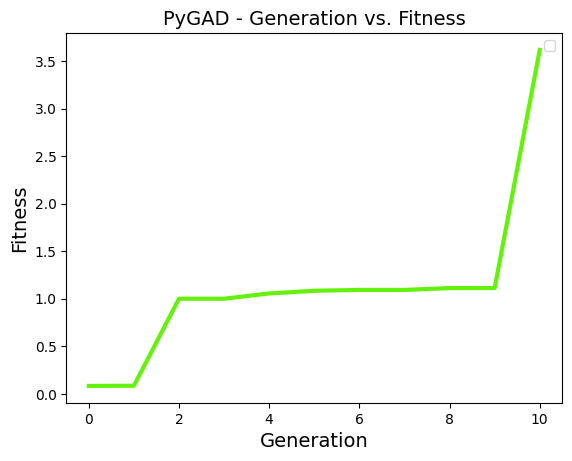

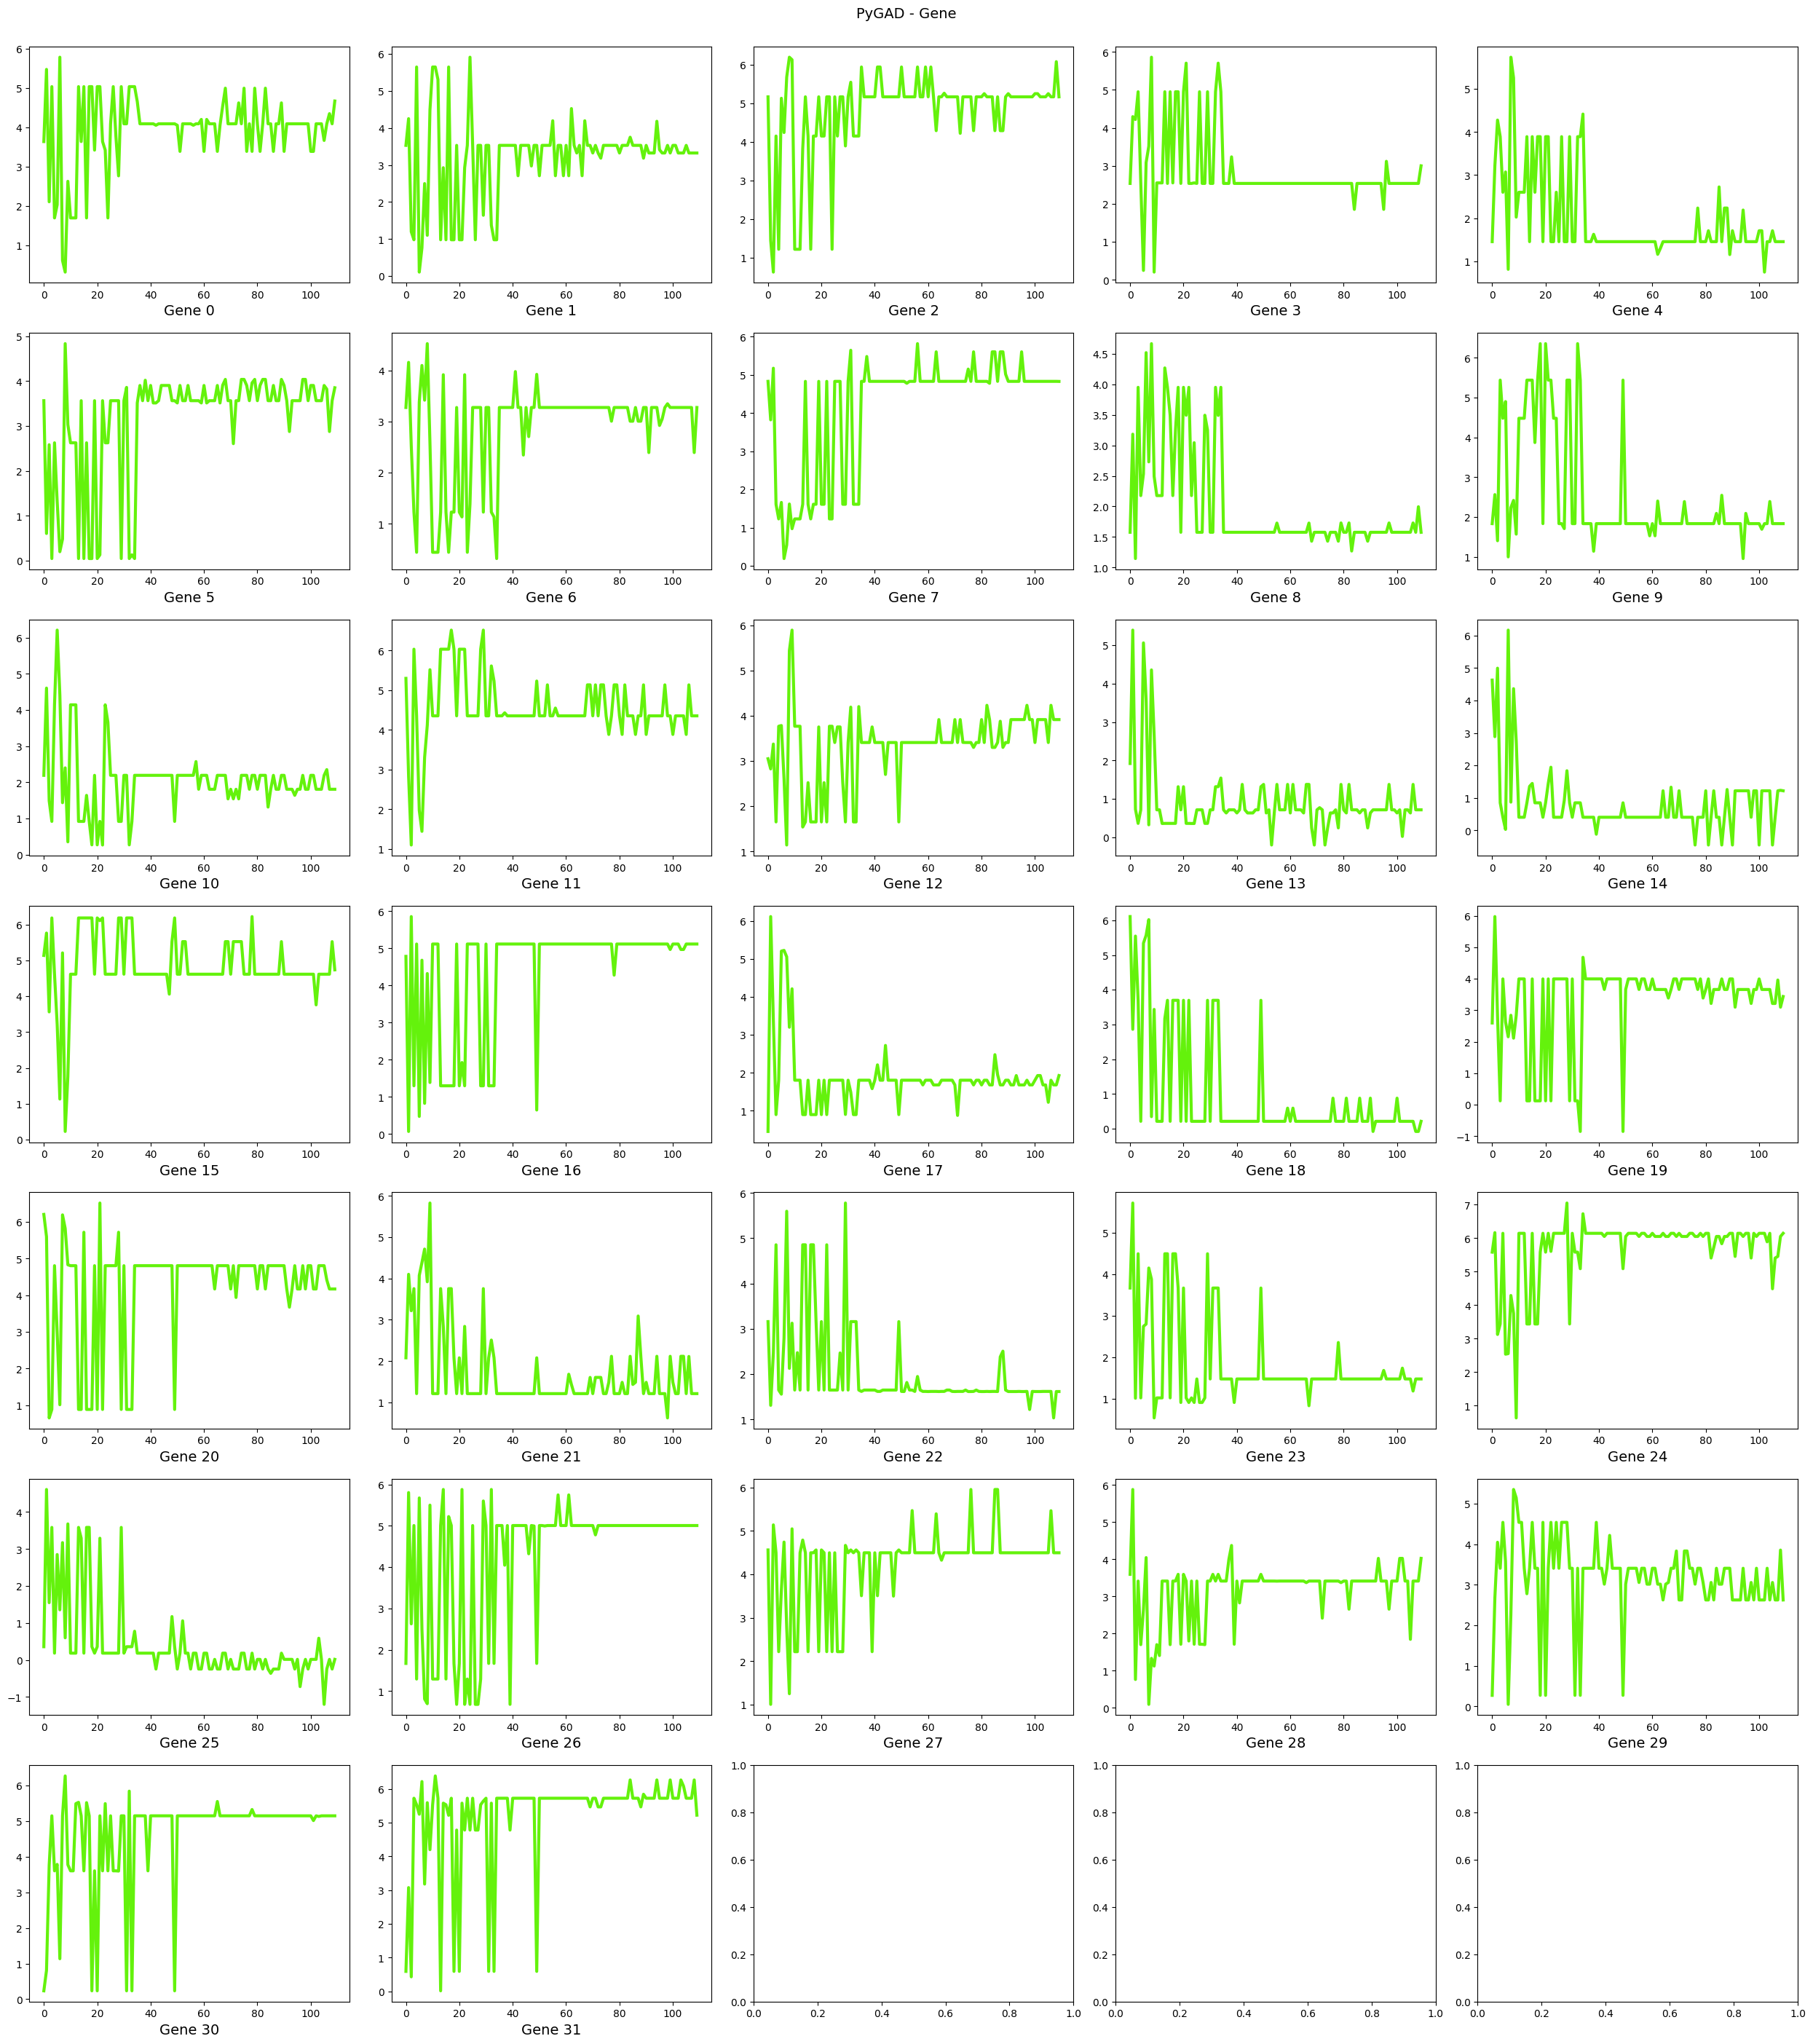

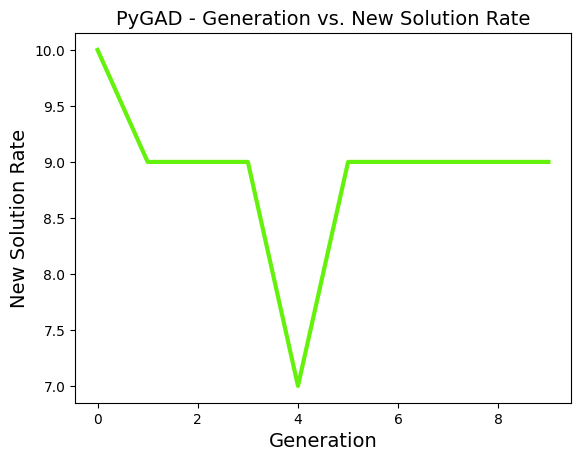

This took 47.79328107833862 to complete
Parameters of the best solution : [3.38905482 3.52905105 5.24693163 2.53682811 1.71060715 3.90222801
 3.27461435 4.82956202 1.57668523 1.69089041 2.19343515 4.35256889
 3.91364342 0.71414477 1.21879002 4.6144486  5.11928713 1.92646099
 0.21123631 3.65921132 4.16974297 1.20822075 1.61697268 1.48084945
 6.14360801 0.01674551 5.00742361 4.49668421 4.02539992 2.6247453
 5.01282931 5.72656117]
Fitness value of the best solution = 3.6179690043086707
The optimal feedback obtained is = [-0.0202303895217493*x1*x2*x3 - 0.0526334140408877*x1*x2 - 0.278540519252498*x1*x3 - 0.805573044937123*x1 - 0.083641799386621*x2*x3 - 0.220293374036381*x2 + 0.305963401768784*x3 + 0.135966082916927
 -0.0669317833494864*x1*x2*x3 - 0.171474222377031*x1*x2 - 0.178201648956155*x1*x3 - 0.494379950390592*x1 - 0.579202048680921*x2*x3 - 1.43699589859309*x2 + 0.0999225639975492*x3 + 0.0127995093290149]
Runtime Statistics. 
 Total = 7094.592785835266. 
         Per Generation = 709.

In [ ]:
%lprun -f main_loop main_loop()

In [ ]:
%%timeit
ans1 = np.array([4.74261723, 1.45203456, 1.86656168, 1.51765877, 5.59770942, 0.67388971, \
 3.96862143, 3.05190222, 0.98289406, 4.84267109, 3.31048983, 0.50671071, \
 4.91497035, 3.37847329, 0.77320326, 1.80864707])
eta_psi_solution = obtain_optimal_feedback(ans1)

Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 29.921883583068848 to complete
Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 27.906506538391113 to complete
Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 26.667669534683228 to complete
Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 28.047175645828247 to complete
Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 26.60495615005493 to complete
Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 26.59963059425354 to complete
Obj ca

In [ ]:
ans2 = np.array([4.7, 1.5, 1.8, 1.2, 5.52, 0.671, \
 3.2, 3.0, 1.1, 1.4, 3.313, 0.50, \
 4.9, 3.3, 0.7, 2])
eta_psi_solution = obtain_optimal_feedback(ans2)

Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.
This took 28.509886980056763 to complete


In [ ]:

theta_array = ans2
%lprun -f optimize_program_when_x_is_ellipsoid optimize_program_when_x_is_ellipsoid(theta_array,  \
                                         ellipsoid_constants, ellipsoid_centre,\
                                          max_noise, len_dict, dim_v, \
                                            dim_m, max_degree, u_max_norm, \
                                              eta_bound, print_point = 0)

Obj called 0 times. Constraint 1 0 times. Constraint 2 0 times. Time for constraint 1 in all    is 0. For constraint 2 is 0.


In [ ]:
#@title Old Two Dimensional Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation

max_noise2 = 3*1e-2

def ellipse_params(c1, c2, a1, a2, theta):
    x1 = c1 + a1 * np.cos(theta)
    x2 = c2 + a2 * np.sin(theta)
    return x1, x2

# Function to compute f1 and f2
def compute_f(c1, c2, a1, a2, theta):
    x1, x2 = ellipse_params(c1, c2, a1, a2, theta)
    dir1 = compute_normal(theta,a1,a2)[1]
    f1 = -x2 - 1.5*x1**2 - 0.5*x1**3 + max_noise2*np.random.random()*dir1
    f2 = 0# Define your function here based on x1 and x2
    return f1, f2

# Function to compute g1 and g2
def compute_g(c1, c2, a1, a2, theta):
    x1, x2 = ellipse_params(c1, c2, a1, a2, theta)
    g1 = 0
    #g2 =  -0.00331751964229724*x1*x2 + 4.7127329059459e-7*x1 - 427.583943014243*x2 - 23.4117086141303
    g2 = -0.0101605661916929*x1**2*x2**2 - 0.0183849712109924*x1**2*x2 + 0.0416923597998396*x1**2 \
- 0.00762162947104746*x1*x2**2 - 0.0360783749974401*x1*x2 + 0.39076185567161*x1 + 0.00203063048874425*x2**2 - 0.177218411665688*x2 - 0.0141966167620039
    return g1, g2
# Function to compute the normal vector

def compute_normal(theta, a1, a2):
    normal = np.array([np.cos(theta)/a1, np.sin(theta)/a2])
    unit_normal = normal/np.abs(np.linalg.norm(normal))
    return unit_normal


# Function to compute angle between two vectors
c1, c2 = ellipsoid_centre[0], ellipsoid_centre[1]
a1, a2 = ellipsoid_constants[0], ellipsoid_constants[1]
l_bound = 0*np.pi
u_bound = 2*np.pi
n_samples_low = 10
n_samples_high = 100
theta_values_ellipse = np.linspace(l_bound,u_bound, n_samples_high)
theta_values = np.linspace(l_bound,u_bound, n_samples_low)
theta_values_high_res = np.linspace(l_bound, u_bound, n_samples_high)


# Plotting
print("Solving the problem: ", problem)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scaling_factor_f = 1
scaling_factor_g = 1
scaling_factor_fg = 1


axs[0, 0].set_title('Drift Vector Field')
x1, x2 = ellipse_params(c1, c2, a1, a2, theta_values)
x1e, x2e = ellipse_params(c1, c2, a1, a2, theta_values_ellipse)
axs[0, 0].plot(x1e, x2e, label='Ellipse', linewidth  = 3)
f1, f2 = compute_f(c1, c2, a1, a2, theta_values)
quiver = axs[0, 0].quiver(x1, x2, f1, f2, color='r', \
                          scale=1/scaling_factor_f, label='Vector Field')
axs[0, 0].set_aspect('equal')  # Set aspect ratio to ensure proper ellipse representation
axs[0, 0].legend()

axs[0, 1].set_title('Control Vector Field')
axs[0, 1].plot(x1e, x2e, label='Ellipse', linewidth  = 3)
g1, g2 = compute_g(c1, c2, a1, a2, theta_values)
quiver = axs[0, 1].quiver(x1, x2, g1*scaling_factor_g , g2*scaling_factor_g, \
                          color='b', scale=1/scaling_factor_g, label='Additional Vector Field')
axs[0, 1].set_aspect('equal')
axs[0, 1].legend()

axs[1, 0].set_title('Resultant Vector Field')
axs[1, 0].plot(x1e, x2e, label='Ellipse', linewidth  = 3, color = 'r')
quiver = axs[1, 0].quiver(x1, x2, (f1 + g1)*scaling_factor_fg, \
                          (f2 + g2)*scaling_factor_fg\
                          , color='g', scale=1/scaling_factor_fg, label='Resultant Vector Field'\
                )
normals = compute_normal(theta_values, a1, a2)
quiver = axs[1, 0].quiver(x1, x2, normals[0]*scaling_factor_fg, (normals[1])*scaling_factor_fg\
                          , color='b', scale=1/scaling_factor_fg)
axs[1, 0].set_aspect('equal')
axs[1, 0].legend()

dot_products = np.zeros_like(theta_values_high_res)
i = 0
for theta in theta_values_high_res:
  normal = compute_normal(theta, a1, a2)
  f1, f2 = compute_f(c1, c2, a1, a2, theta)
  g1, g2 = compute_g(c1, c2, a1, a2, theta)
  dot_product = ((f1 + g1)*normal[0] + (f2 + g2)*normal[1])/np.sqrt((f1 + g1)**2 + (f2 + g2)**2) \
  if np.sqrt((f1 + g1)**2 + (f2 + g2)**2) > 0 else 0
  dot_products[i] = dot_product
  i += 1
print(max(dot_products))


axs[1,1].set_title('Normalized Dot Product (Cosine()) as a Function of theta')
axs[1,1].plot(theta_values_high_res, dot_products, color='blue', label='Scatter Plot')
plt.axhline(0, color='red', linestyle='--', label='y=0')

plt.show()

Average dot product:  -0.7154138563470377
Worst case dot product:  -0.12896561325726952


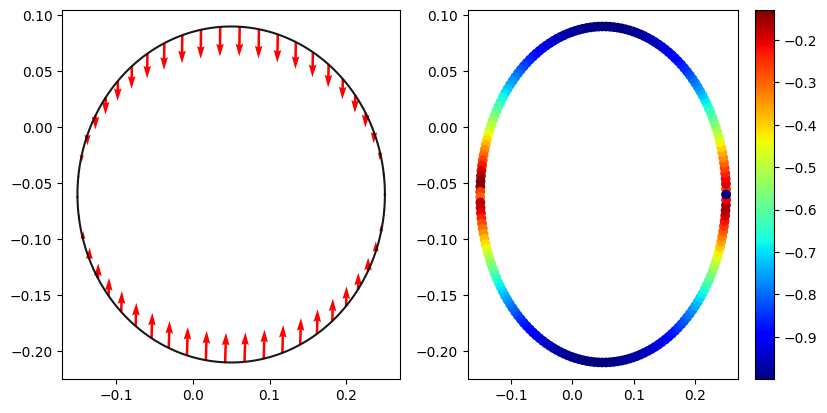

In [ ]:
#@title New Two Dimensional Naive Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation

c1, c2 = ellipsoid_centre[0], ellipsoid_centre[1]
a1, a2 = ellipsoid_constants[0], ellipsoid_constants[1]

n_samples = 200

theta1 = np.linspace(0, 2 * np.pi, n_samples)
x1 = np.ravel(c1 + a1 * np.cos(theta1))
x2 = np.ravel(c2 + a2 * np.sin(theta1))

n1 = (x1 - c1)/a1**2
n2 = (x2 - c2)/a2**2
n_norm = np.sqrt(n1**2 + n2**2) + 1e-8

f1 = -x2 - 1.5*x1**2 - 0.5*x1**3
f2 = 0*x1

g1 = 0
g2 = -n2

z1, z2 = 1, 1
h1 = f1 + z1*g1
h2 = f2 + z2*g2

h_norm =  np.sqrt(h1**2 + h2**2) + 1e-8


dot_product = (h1*n1 + h2*n2)/(n_norm*h_norm)
print("Average dot product: ", dot_product.mean())
print("Worst case dot product: ", dot_product.max())


fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x1, x2, color='black', alpha = 0.9);
skip = 4
ax.quiver(x1[::skip], x2[::skip], h1[::skip], h2[::skip],  color = 'red')
ax1 = fig.add_subplot(1, 2, 2)
pcm = ax1.scatter(x1,x2, cmap='jet',c=dot_product)
plt.colorbar(pcm, ax = ax1)
plt.show()


Average dot product:  -0.5596606535916393
Worst case dot product:  0.9880408322292443


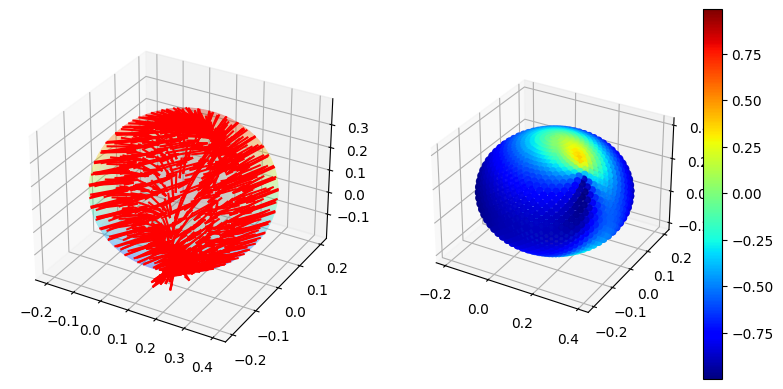

In [ ]:
#@title Three Dimensional Plotter
'''
https://matplotlib.org/2.0.2/examples/mplot3d/surface3d_demo2.html
'''
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.tri import Triangulation
%matplotlib inline

c1, c2, c3 = ellipsoid_centre[0], ellipsoid_centre[1], ellipsoid_centre[2]
a1, a2, a3 = ellipsoid_constants[0], ellipsoid_constants[1], ellipsoid_constants[2]

n_samples = 50
theta1 = np.linspace(0, 2 * np.pi, n_samples)
theta2 = np.linspace(0, 2 * np.pi, n_samples)
theta1, theta2 = np.meshgrid(theta1, theta2)
x1 = np.ravel(c1 + a1 * np.cos(theta1)*np.cos(theta2))
x2 = np.ravel(c2 + a2 * np.cos(theta1)*np.sin(theta2))
x3 = np.ravel(c3 + a3 * np.sin(theta1))

n1 = (x1 - c1)/a1**2
n2 = (x2 - c2)/a2**2
n3 = (x3 - c3)/a3**2
n_norm = np.sqrt(n1**2 + n2**2 + n3**2) + 1e-8

f1 = 0*x1
f2 = 0*x2
f3 = x1*x2


g1 = -0.0202303895217493*x1*x2*x3 - 0.0526334140408877*x1*x2 - 0.278540519252498*x1*x3 - 0.805573044937123*x1 - 0.083641799386621*x2*x3 - 0.220293374036381*x2 + 0.305963401768784*x3 + 0.135966082916927
g2 =  -0.0669317833494864*x1*x2*x3 - 0.171474222377031*x1*x2 - 0.178201648956155*x1*x3 - 0.494379950390592*x1 - 0.579202048680921*x2*x3 - 1.43699589859309*x2 + 0.0999225639975492*x3 + 0.0127995093290149
g3 = 0

# g1 = -n1
# g2 = -n2
# g3 = 0

z1, z2, z3 = 1, 1, 1
h1 = f1 + z1*g1
h2 = f2 + z2*g2
h3 = f3 + z3*g3
h_norm =  np.sqrt(h1**2 + h2**2 + h3**2) + 1e-8


dot_product = (h1*n1 + h2*n2 + h3*n3)/(n_norm*h_norm)
print("Average dot product: ", dot_product.mean())
print("Worst case dot product: ", dot_product.max())

tri = Triangulation(np.ravel(theta1), np.ravel(theta2))

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x1, x2, x3, triangles=tri.triangles, cmap='jet', linewidths=0.2, alpha = 0.1);
skip = 4
ax.quiver(x1[::skip], x2[::skip], x3[::skip], h1[::skip], h2[::skip], h3[::skip], \
        length=0.1, normalize=True, color = 'red')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
pcm = ax1.scatter(x1,x2,x3,cmap='jet',c=dot_product)
plt.colorbar(pcm, ax = ax1)
plt.show()
